In [561]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


<Axes: xlabel='longitude', ylabel='latitude'>

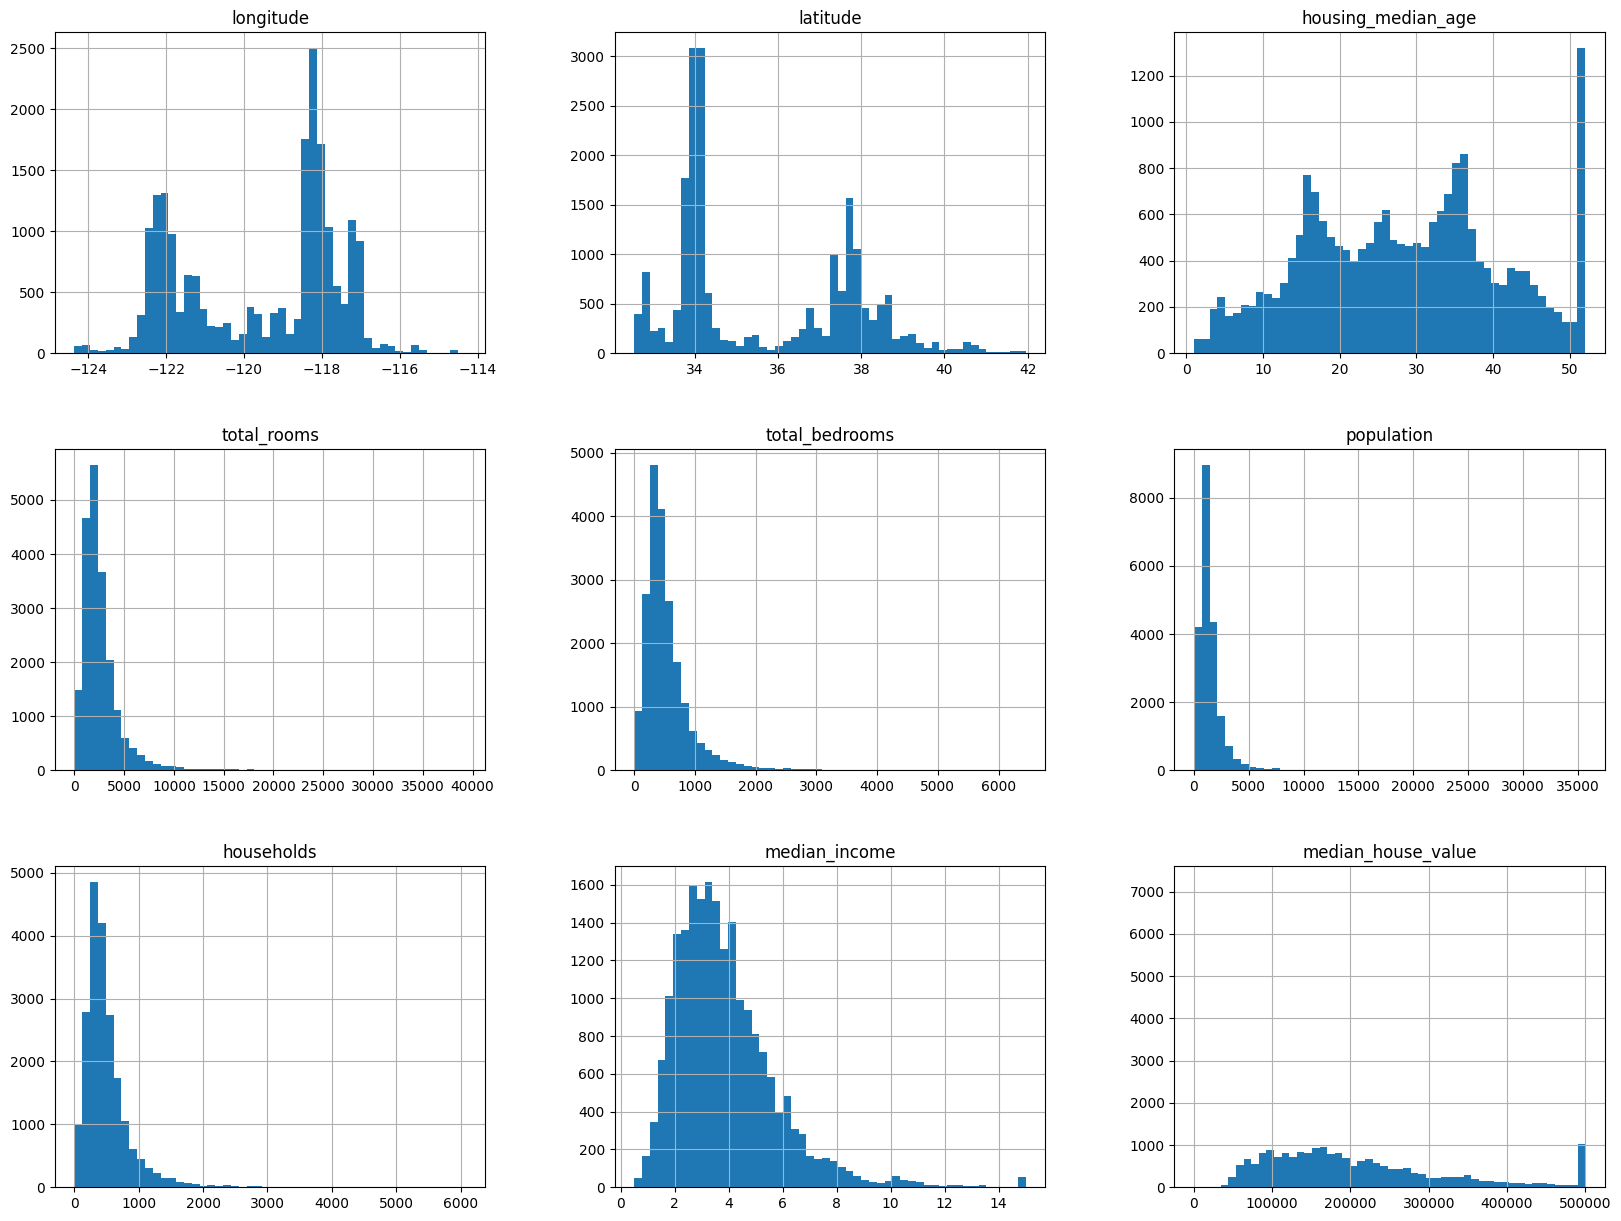

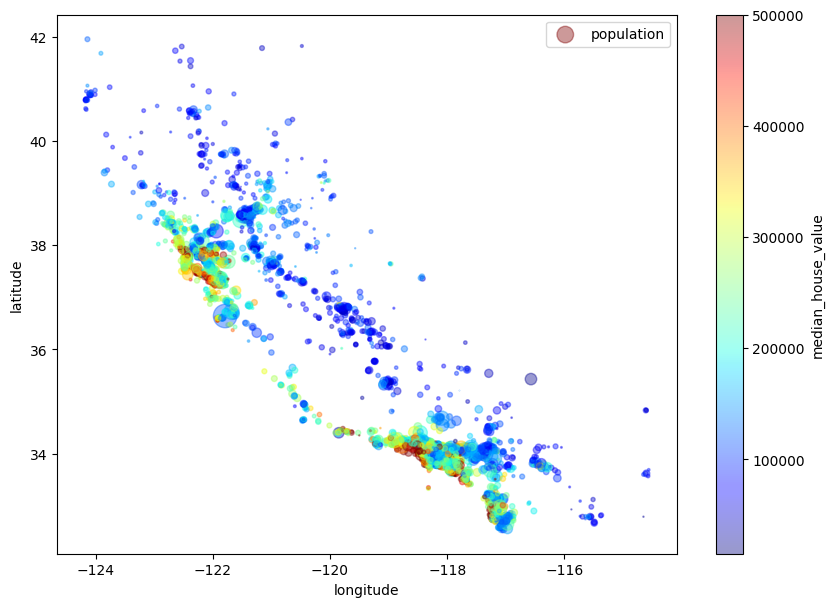

In [562]:
housing_data = pd.read_csv('downloads/housing.csv')
housing_data.head()
housing_data.info()

train_set, test_set = train_test_split(housing_data, test_size = 0.2, random_state = 42)

housing_data.hist(bins=50, figsize=(20,15))
housing_data['income_cat'] = pd.cut(housing_data['median_income'], 
                                    bins =[0., 1.5, 3.0, 4.5, 6., 
                                           np.inf],labels=[1,2,3,4,5] )
housing_data['income_cat'].hist()

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)

for train_index, test_index in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_index]
    strat_test_set = housing_data.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

housing_data = strat_test_set.copy()

housing_data.plot(x="longitude", y="latitude", kind="scatter", alpha=0.4,
                s=housing_data['population']/100, label='population', figsize=(10,7),
                c='median_house_value', cmap=plt.get_cmap('jet'))

<Axes: xlabel='median_income', ylabel='median_house_value'>

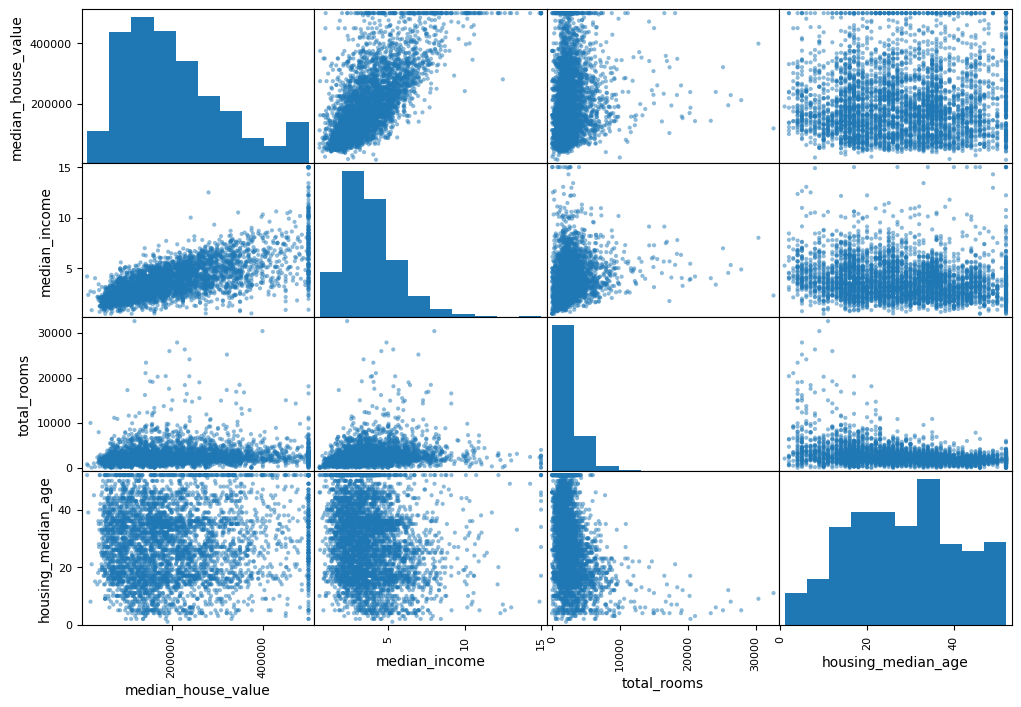

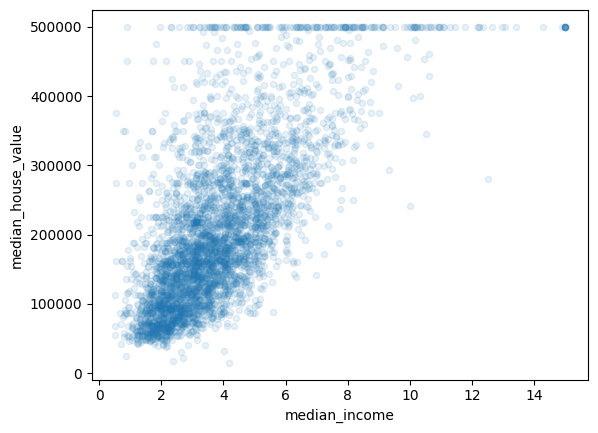

In [563]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing_data[attributes], figsize=(12,8))

housing_data.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

In [564]:
housing_data["rooms_per_household"] = housing_data["total_rooms"] / housing_data['households']
housing_data["bedrooms_per_room"] = housing_data["total_bedrooms"] / housing_data['total_rooms']
housing_data["population_per_household"] = housing_data["population"] / housing_data["households"]

corr_matrix = housing_data.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

housing_data = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

/var/folders/pn/dyw6gjhx64x2qf0zzv2qx82h0000gn/T/ipykernel_81024/4115000616.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing_data.corr()


In [565]:
imputer = SimpleImputer(strategy='median')
housing_num =housing_data.drop("ocean_proximity", axis = 1)
imputer.fit(housing_num)

imputer.statistics_
housing_num.median().values

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

housing_cat = housing_data[['ocean_proximity']]

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [566]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # Properly named constructor
        self.add_bedrooms_per_room = add_bedrooms_per_room  # Properly set the attribute
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing_data.values)

In [567]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing_data)


In [568]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [569]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

lr_housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, lr_housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring = 'neg_mean_squared_error', cv =10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard Deviation: 2880.3282098180694


In [570]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

tr_housing_predictions = tree_reg.predict(housing_prepared)
tr_mse = mean_squared_error(housing_labels, tr_housing_predictions)
tr_rmse = np.sqrt(tr_mse)

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [71806.22181317 69325.15025436 69146.91917868 72080.25750697
 69267.48529867 78431.76486891 71053.29966654 73146.23225149
 69157.90290094 71829.4278942 ]
Mean: 71524.46616339197
Standard Deviation: 2687.5359508611596


In [571]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10)
forest_reg.fit(housing_prepared, housing_labels)

fr_housing_predictions = forest_reg.predict(housing_prepared)
fr_mse = mean_squared_error(housing_labels, fr_housing_predictions)
fr_rmse = np.sqrt(fr_mse)

fr_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring='neg_mean_squared_error', cv=10)
fr_rmse_scores = np.sqrt(-fr_scores)

display_scores(fr_rmse_scores)

Scores: [54037.66249443 51812.07921402 49652.92272591 54247.22923807
 50761.31467665 55107.68928869 54902.06790395 52374.19222708
 52720.37769848 56609.93999264]
Mean: 53222.54754599122
Standard Deviation: 2032.844100549544


In [584]:
from sklearn.model_selection import GridSearchCV
from scipy import stats

forest_reg = RandomForestRegressor(n_estimators=5)

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
grid_search.best_estimator_
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
    
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_endcoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,attributes), reverse=True)

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse =  np.sqrt(final_mse)




64447.60649165357 {'max_features': 2, 'n_estimators': 3}
55266.13659288184 {'max_features': 2, 'n_estimators': 10}
52881.18119759747 {'max_features': 2, 'n_estimators': 30}
60440.82768207271 {'max_features': 4, 'n_estimators': 3}
52581.99248088461 {'max_features': 4, 'n_estimators': 10}
50432.749978858374 {'max_features': 4, 'n_estimators': 30}
58444.218956515535 {'max_features': 6, 'n_estimators': 3}
52155.85608304468 {'max_features': 6, 'n_estimators': 10}
50207.42143907496 {'max_features': 6, 'n_estimators': 30}
59264.995316041386 {'max_features': 8, 'n_estimators': 3}
52066.329635986905 {'max_features': 8, 'n_estimators': 10}
50012.005781482505 {'max_features': 8, 'n_estimators': 30}
62451.40011353137 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54341.74708970502 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60055.254099661775 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53317.341363398424 {'bootstrap': False, 'max_features': 3, 'n_estimato

In [585]:
from scipy import stats

confidence = 0.95
squared_errors  = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale = stats.sem(squared_errors)))

array([45914.4298904, 49883.4292595])